# Exercise 4: recommender System

In [9]:
#check if notebook runs in colab
import sys
IN_COLAB = 'google.colab' in sys.modules
print('running in Colab:',IN_COLAB)
path='..'
if IN_COLAB:
  #in colab, we need to clone the data from the repo
  !git clone https://github.com/keuperj/DataScienceSS20.git
  path='DataScienceSS20'

running in Colab: False


## Code from the lecture

In [10]:
#read data to DataFrames
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv(path+'/DATA/movielens100k/u.user', sep='|', names=u_cols, encoding = "ISO-8859-1")

r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv(path+'/DATA/movielens100k/u.data', sep='\t', names=r_cols, encoding = "ISO-8859-1")

m_cols=['movie_id', 'title', 'release date', 'video release date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies = pd.read_csv(path+'/DATA/movielens100k/u.item', sep='|', names=m_cols ,encoding = "ISO-8859-1" )

In [11]:
def getTopN(movie_id,N=5):
    return D[movie_id,:].argsort()[-N:]

def getIDbyName(name):
    if np.size(movies.movie_id[movies.title.str.contains(name)]) > 0:
        m = int(movies.movie_id[movies.title.str.contains(name)][:1]), str(movies.title[movies.title.str.contains(name)][:1])
        return m[0]-1
    else:
        return -1
    
def getNameByID(IDs):
    res=movies.iloc[IDs]
    return res.title

def CII(title):
    if getIDbyName(title) > 0:
        print ("recommending movies for: '" + str(getNameByID(getIDbyName(title)))+"'")
        return getNameByID(getTopN(getIDbyName(title)))[::-1]
    else:
        print ("no movie title containing " + str(title) + "found...")
        
def Score_byID(ID, D, Test):
    #print ("Hit Scores for: ", getNameByID(ID))
    res_id = getTopN(ID,D)[::-1]
    res_title = getNameByID(getTopN(ID,D))[::-1]
    res_score = Test[res_id]
    return res_id, res_title, res_score, np.mean(res_score)
    
#compute scores for all test users
def test_Score(D_train, R_test):
    userScores=[]
    for i in range(R_test.shape[0]):
        userScore=0
        userTop = np.argsort(R_test[i])[-5:]
        for e in userTop:
            res_id, res_title, res_score, av_score = Score_byID(e,D_train, R_test[i])
            userScore+=av_score
        userScores.append(userScore/(5))
    return userScores

In [12]:
#gerate matrix (this can be done more efficiently!)
R=np.zeros((np.shape(users)[0],np.shape(movies)[0]))
for i in range(np.shape(ratings)[0]):
    R[ratings['user_id'][i]-1, ratings['movie_id'][i]-1]=ratings['rating'][i]

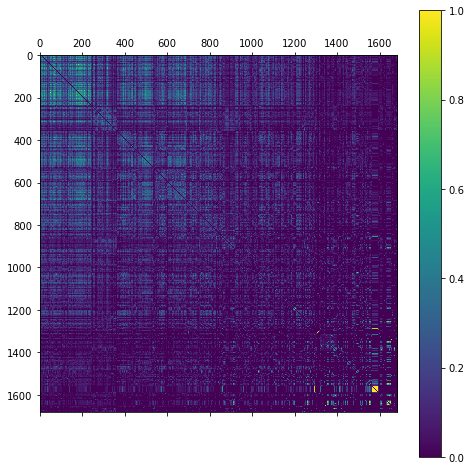

In [17]:
import scipy.spatial
D=scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(R.T, metric='cosine'))
D=np.abs(np.nan_to_num( D-1)) #dist to similarity 
np.fill_diagonal(D,0) #set self-dist to zero

np.save("cos_movie_dist",D)

## 4.1 Alternative Distance Measures
Implement a different distance measure, e.g. eucledian and compare the ressults.

## 4.2 Baseline Results
Implement and compare results of
* random recommendations
* allways recommending the top 5 movies (over all users)

## 4.3 SVD
Implement the SVD approach. Hints: 
* use numpy.linalg.svd()
* apply SVD on $R$
* plot the singular values and decide where to cut off the reconstruction
* reconstruct R and evaluate $R'$
* compute the distance between two movies using $R'$


4.1

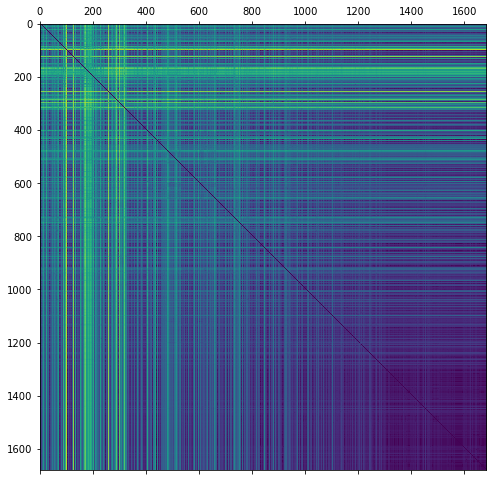

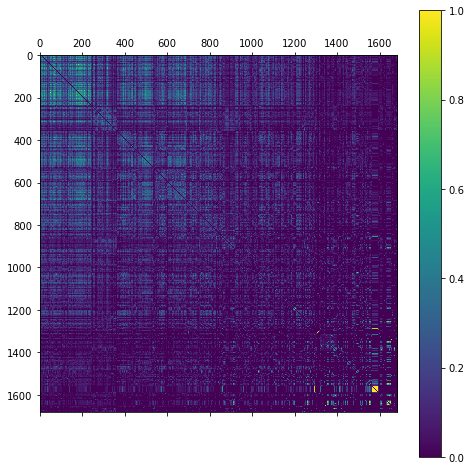

In [30]:
D_EUG = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(R.T, metric='euclidean'))
D_EUG=np.abs(np.nan_to_num( D_EUG-1)) #dist to similarity 
np.fill_diagonal(D_EUG,0) #set self-dist to zero

np.save("euc_movie_dist",D_EUG)

plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.matshow(D_EUG)
plt.matshow(D)
plt.colorbar() 

4.3

In [18]:
U, S, V = np.linalg.svd(R)

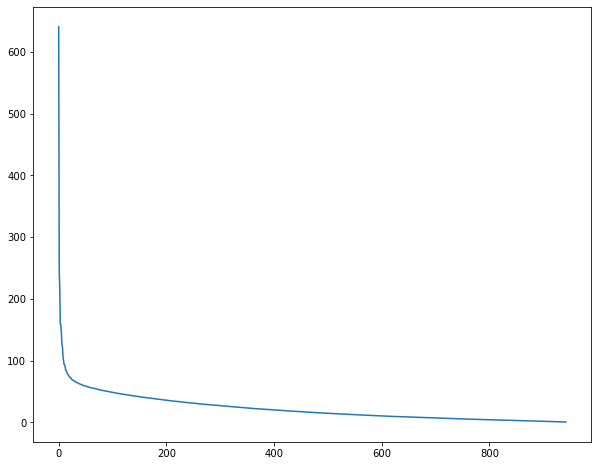

In [23]:
plt.plot(S)

In [27]:
singValue = 200
R_ = np.dot(U[:,:singValue] * S[:singValue], V[:singValue,:])

array([[ 5.09289962e+00,  3.04433657e+00,  2.86249419e+00, ...,
        -1.90427835e-02, -5.98010867e-02,  1.55508340e-01],
       [ 4.03721079e+00,  1.07026334e-01,  6.48256252e-01, ...,
         1.52694292e-04, -1.35271357e-02, -1.76687112e-02],
       [-6.09784231e-01, -5.49638541e-01, -4.47159541e-01, ...,
         5.41648907e-02, -1.19272935e-02, -2.84297364e-02],
       ...,
       [ 4.14316427e+00, -9.64646530e-02,  3.27466588e-01, ...,
        -4.27885216e-03,  2.32271549e-02, -1.44625276e-02],
       [ 2.34826085e-01,  5.04503111e-01,  5.58826352e-01, ...,
        -2.41359211e-02, -4.85094269e-02, -7.31188441e-02],
       [ 2.74357979e-03,  3.99269798e+00,  1.17216929e+00, ...,
        -1.20289780e-02,  5.44326597e-02, -9.53140464e-03]])

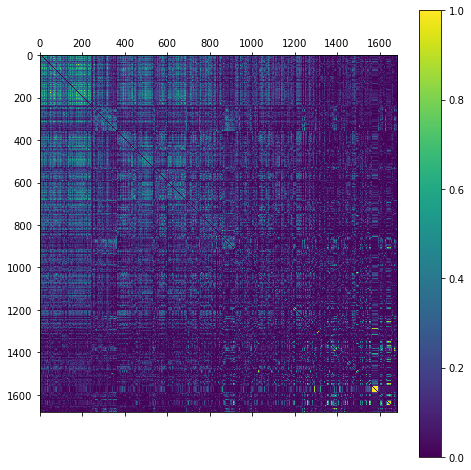

In [32]:
D_R_=scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(R_.T, metric='cosine'))
D_R_=np.abs(np.nan_to_num( D_R_-1)) #dist to similarity 
np.fill_diagonal(D_R_,0) #set self-dist to zero

np.save("cos_svd_movie_dist",D_R_)

plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.matshow(D_R_)
plt.colorbar() 